In [30]:
ENV["GKS_ENCODING"] = "utf-8"
#using GroupedErrors
using JuliaDB, Plots, StatsPlots, StatsBase, Interpolations, Statistics, LaTeXStrings, Random, Distributions,
JLD2, Colors, Plots.PlotMeasures, Dates, LsqFit
gr()
path = chop(pwd(),tail=7)

"/home/lucy/radiotrack/"

In [31]:
string(path, "data/radiotrack.csv")


"/home/lucy/radiotrack/data/radiotrack.csv"

In [32]:
t = loadtable(string(path, "data/radiotrack.csv"))

t = JuliaDB.pushcol(t, :x_displacement, select(t, (:X, :start_x) => row -> row.X-row.start_x))
t = JuliaDB.pushcol(t, :y_displacement, select(t, (:Y, :start_y) => row -> row.Y-row.start_y))

t = JuliaDB.pushcol(t, :SD, (:X, :start_x, :Y, :start_y) => row -> (row.X-row.start_x)^2 + (row.Y-row.start_y)^2)
sunset = 21*3600 .+ 60 .*[3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 24, 25, 25, 26, 27, 27, 28];
days = unique(select(t, :studyday));



┌ Warning: `pushcol(t, key::Union{Int, Symbol}, val)` is deprecated, use `transform(t, key => val)` instead.
│   caller = top-level scope at In[32]:2
└ @ Core In[32]:2
┌ Warning: `pushcol(t, key::Union{Int, Symbol}, val)` is deprecated, use `transform(t, key => val)` instead.
│   caller = top-level scope at In[32]:4
└ @ Core In[32]:4
┌ Warning: `pushcol(t, key::Union{Int, Symbol}, val)` is deprecated, use `transform(t, key => val)` instead.
│   caller = top-level scope at In[32]:5
└ @ Core In[32]:5


In [33]:
gr()
t2 = loadtable(string(path, "data/radiotrack_roosts.csv"))
scatter((select(t,:X).-minimum(select(t,:X)))./1e3 .+ 0.1, (select(t,:Y).- minimum(select(t,:Y)))./1e3, markersize=4, label="Bat locations")
scatter!((select(t2,:Roost_x).- minimum(select(t,:X)))./1e3 .+ 0.1,(select(t2,:Roost_y).- minimum(select(t,:Y)))./1e3, markersize=8, label="Day roosts",marker=:diamond)
plot!(legend=:outertopright, aspect_ratio=1,xlabel="x (km)",ylabel="y (km)",tickfontsize=12, legendfontsize=12, guidefontsize=12, grid=:off,
    size=(600,400), margin=10px)
savefig(string(path, "figs/track_locations.pdf"))

In [34]:
i = 1
plot()
colours = [:fuchsia,:greenyellow,:blue,:red,:orange,:black]
for (idx,j) in enumerate(unique(select(filter(x -> x == i , t; select = :BatID), :studyday)))
    plot!((select(filter(x -> (x.BatID == i)&& (x.studyday ==j),t),:X).- minimum(select(t,:X)))./1e3, 
        (select(filter(x -> (x.BatID == i)&& (x.studyday ==j),t),:Y).- minimum(select(t,:Y)))./1e3, 
        width=2, label=string("Day ",j), color=colours[idx])
end
for (idx,j) in enumerate(unique(select(filter(x -> x == i , t; select = :BatID), :studyday)))
    scatter!((select(filter(x -> (x.BatID == i)&& (x.studyday ==j),t),:X).- minimum(select(t,:X)))./1e3, 
        (select(filter(x -> (x.BatID == i)&& (x.studyday ==j),t),:Y).- minimum(select(t,:Y)))./1e3, 
        markersize=4, label="", color=colours[idx])
end
scatter!((select(t2,:Roost_x).- minimum(select(t,:X)))[1:2]./1e3 .+ 0.1,
    (select(t2,:Roost_y).- minimum(select(t,:Y)))[1:2]./1e3, markersize=8, 
    label="Day roosts",marker=:diamond, color=:cadetblue1)
plot!(legend=:outertopright, aspect_ratio=1,xlabel="x (km)",ylabel="y (km)",tickfontsize=12, legendfontsize=12, guidefontsize=12, grid=:off,
    size=(600,400), margin=10px, ylims=[0 5])
savefig(string(path, "figs/bat1_locations.pdf"))

In [35]:
xp = []
yp = []
for i = range(0, stop=2pi, length=100)    
    append!(xp, sin(i)*1600)
    append!(yp, cos(i)*1600)
end

In [36]:
i = 5
j = 6
idx = j
A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
 
xdis1 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :x_displacement)
ydis1 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :y_displacement);

i = 6
j = 8
idx = j
A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
 
xdis2 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :x_displacement)
ydis2 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :y_displacement);


i = 6
j = 10
idx = j
A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
 
xdis3 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :x_displacement)
ydis3 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :y_displacement);

i = 7
j = 8
idx = j
A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
 
xdis4 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :x_displacement)
ydis4 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :y_displacement);



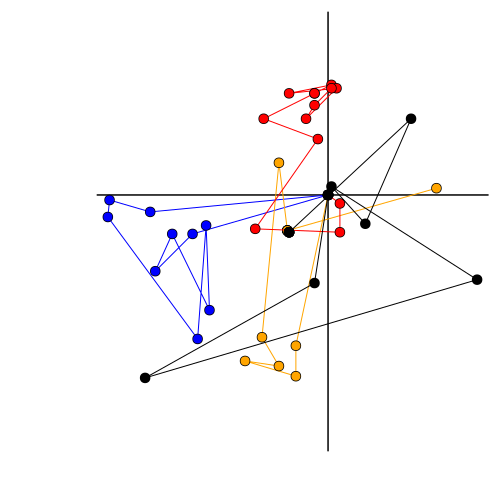

In [37]:
gr()
plt = hline([0,0], label="", color=:black)
vline!([0,0], label="", color=:black)
plot!(xdis1, ydis1, label="Regression", color=:blue)
scatter!(xdis1,ydis1, label="Recorded points", color=:blue, markersize=5)
plot!(xdis2, ydis2, label="Regression", color=:orange)
scatter!(xdis2,ydis2, label="Recorded points", color=:orange, markersize=5)
plot!(xdis3, ydis3, label="Regression", color=:red)
scatter!(xdis3,ydis3, label="Recorded points", color=:red, markersize=5)
plot!(xdis4, ydis4, label="Regression", color=:black)
scatter!(xdis4,ydis4, label="Recorded points", color=:black, markersize=5)


#plot!(xp, yp, label="Boundary", color=:green)


plot!(grid=false, aspect_ratio=1, showaxis=false, legend=false,
    size=(500,500),
    tickfontsize=18, guidefontsize=20, legendfontsize=10)

savefig(string(path, "figs/Diffusion_eg.pdf"))
plot(plt)

In [56]:
t2 = loadtable(string(path, "data/radiotrack_roosts.csv"))

dt = 200.
times = []
sdists = []
xdists = []
ydists = []
ts = []
l = []
n_locations = 0
n_locations_all = 0
for i in unique(select(t, :BatID))
    for (idx,j) in enumerate(unique(select(filter(x -> x == i , t; select = :BatID), :studyday)))
           roost = [select(filter(x -> (x.BatID == i) && (x.studyday ==(j+1)), t2), :Roost_x)  select(filter(x -> (x.BatID == i) && (x.studyday ==j+1), t2), :Roost_y)]
             A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
            n_locations_all += length(A_t)   
            if length(roost) >0
            A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
            n_locations += length(A_t)
            tfs = hour.(DateTime.(A_t, "HH:MM:SS"))*3600 + minute.(DateTime.(A_t, "HH:MM:SS"))*60 + second.(DateTime.(A_t, "HH:MM:SS")) .- sunset[findfirst(x-> x==j, days)]   
            tfs[findall(tfs .< -10000)] .+= 24*3600
            tfs[findall(tfs.<0)] .= 0
            if length(tfs) > 1
                knots = (tfs,)
                itpx = interpolate(knots, select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :X).-roost[1], Gridded(Linear()))
                itpy = interpolate(knots, select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Y).-roost[2], Gridded(Linear()))
                for (j,t) in enumerate(dt:dt:8*3600)
                    if t < tfs[end] && t > tfs[1]
                        append!(ts, t)
                        append!(sdists, itpx(t)^2+itpy(t)^2)
                        append!(xdists, itpx(t))
                        append!(ydists, itpy(t))
                    end
                end
            end
        end
    end
end

hours = ts./3600;
t3 = table((t=ts, hour=hours, sd=sdists, xd=xdists, yd=ydists));

In [57]:
# sqrt(var(x, corrected=true) / length(x)).

meansd = []
meanxd = []
meanyd = []
meand = []
stdsd = []
varsd = []
lngth = [] 
sstot = 0
for (i, tps) in enumerate(dt:dt:maximum(ts))
    append!(meansd, mean(sdists[ts.==tps]))
    append!(meanxd, mean(xdists[ts.==tps]))
    append!(meanyd, mean(ydists[ts.==tps]))
    append!(meand, mean(xdists[ts.==tps].+ydists[ts.==tps]))
    append!(stdsd, Statistics.std(sdists[ts.==tps]))
    append!(varsd, StatsBase.var(sdists[ts.==tps]))
    append!(lngth, length(sdists[ts.==tps]))
end
semsd = sqrt.(varsd./lngth);
semsd[isnan.(semsd)] .= 0;

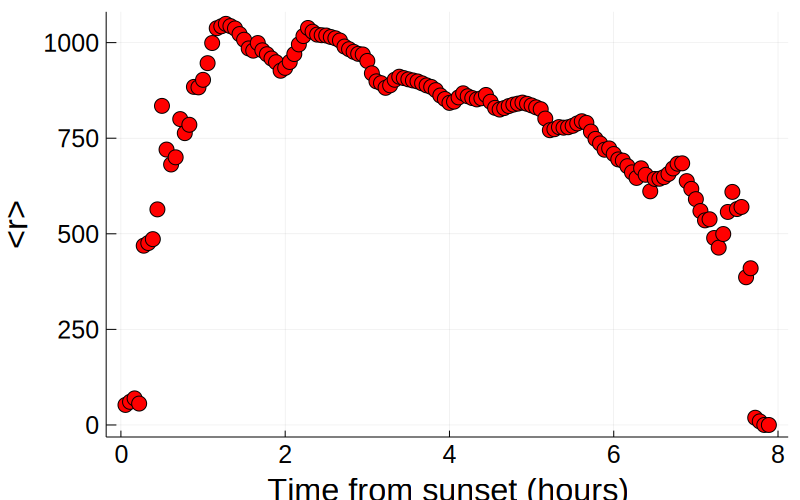

In [58]:
scatter((dt:dt:maximum(ts))./3600., sqrt.(meansd), label="",
    xlabel=string("Time from sunset (hours)"), ylabel="<r>", 
    markersize=8, color=:red,
    size=(800,500),
    tickfontsize=17, guidefontsize=22)

In [59]:
t = dt:dt:maximum(ts)
@save "radiotrack.jld2" t meansd semsd stdsd

In [60]:
T = 4.35 *10^3
@. model(t, D) = 4*D[1]*t+D[2]
xdata = select(filter(x -> (x.t <T),t3), :t)
ydata = select(filter(x -> (x.t < T), t3), :sd)
D0 = [100., 100.0]
fit_ = curve_fit(model, xdata, ydata, D0)
D_estimate = coef(fit_)
coef(fit_), confidence_interval(fit_, 0.1)

([64.6856, -72815.8], Tuple{Float64,Float64}[(33.1594, 96.2118), (-4.72991e5, 3.2736e5)])

In [61]:
T = 4.19 *10^3
@. model(t, p) = p[1]*t + p[2]
xdata = select(filter(row -> (row.t > T), t3), :t)
ydata = select(filter(row -> (row.t > T), t3), :sd)
p0 = [1., 1.]
fit_ = curve_fit(model, xdata, ydata, p0)
p = coef(fit_)

dt_sim = 10
msds_linear = []

for (i, tps) in enumerate(dt:dt:maximum(ts))
    if tps<T
        append!(msds_linear, 4*D_estimate[1]*tps+D_estimate[2])
    else
        append!(msds_linear,(p[1]*tps + p[2]))
    end
end


semsd = sqrt.(varsd./lngth);
semsd[isnan.(semsd)] .= 0;


In [62]:

T = 4.19 *10^3
@. model(t, p) = p[1]*t^2 + p[2]*t + p[3]
xdata = select(filter(row -> (row.t > T), t3), :t)
ydata = select(filter(row -> (row.t > T), t3), :sd)
p0 = [1.,1.,1.]
fit_ = curve_fit(model, xdata, ydata, p0)
p = coef(fit_)

dt_sim = 10
msds_quadratic = []

for (i, tps) in enumerate(dt:dt:maximum(ts))
    if tps<T
        append!(msds_quadratic, 4*D_estimate[1]*tps+D_estimate[2])
    else
        append!(msds_quadratic,(p[1]*tps^2 + p[2]*tps + p[3]))
    end
end

semsd = sqrt.(varsd./lngth);
semsd[isnan.(semsd)] .= 0;



In [63]:
T = 4.19 *10^3
@. model(t, p) = p[1]*t^2 + p[2]*t + p[3]
xdata = select(filter(row -> (row.t > T), t3), :t)
ydata = select(filter(row -> (row.t > T), t3), :sd)
p0 = [1.,1.,1.]
fit_ = curve_fit(model, xdata, ydata, p0)
p = coef(fit_)

dt_sim = 10
msds_quadratic = []

for (i, tps) in enumerate(dt:dt:maximum(ts))
    if tps<T
        append!(msds_quadratic, 4*D_estimate[1]*tps+D_estimate[2])
    else
        append!(msds_quadratic,(p[1]*tps^2 + p[2]*tps + p[3]))
    end
end

semsd = sqrt.(varsd./lngth);
semsd[isnan.(semsd)] .= 0;


In [64]:
sstot = 0
ssres_linear = 0
ssres_quadratic = 0
ssres_simulation = 0
    for (i,msd) in enumerate(meansd)  
        sstot += (msd - mean(meansd))^2
        ssres_linear += (msds_linear[i]-msd)^2
        ssres_quadratic += (msds_quadratic[i]-msd)^2
    end


r2_quadratic = 1 - ssres_quadratic/sstot
r2_linear = 1 - ssres_linear/sstot

0.9269586215364078

In [85]:
L"s"

L"$s$"

In [91]:
plot(xlabel=string("Time from sunset (hours)"), ylabel="MSD (m²)", 
    markersize=8, color=:red,
    size=(800,500),
    tickfontsize=17, guidefontsize=22)
scatter!((dt:dt:maximum(ts))./3600., meansd./10^6, label="",
    ribbon=semsd./10^6, fill=:orange, 
    markersize=8, color=:red,
    size=(800,500),
    tickfontsize=17, guidefontsize=22,
    margin=10mm)

savefig(string(path, "figs/RadioTrack_MSD.pdf"))

In [68]:
function diffusion_step(D,dt,x,y)
    return x + rand(Normal(0,sqrt(2*D*dt))), y + rand(Normal(0,sqrt(2*D*dt)))
end

function drift_step(D,chi,dt,t,tD,x,y,r_threshold,r_exp,t_exp)
    r = sqrt(x^2+y^2)
    if r > r_threshold 
        xdir = x/sqrt(x^2+y^2)
        ydir = y/sqrt(x^2+y^2)
        return x - rand(Normal(xdir*chi*dt*(r^r_exp),sqrt(2*D*dt))), y - rand(Normal(ydir*chi*dt*(r^r_exp),sqrt(2*D*dt)))
    else
        return 0,0
    end
end

function MSD(x,y)
    Dist = x .+ y
    SD = x.^2 .+ y.^2;
    meansd = Array{Float64}(undef,size(SD)[2])
    for i = 1:size(SD)[2]
        if length(SD[:,i][SD[:,i].!=0]) > 0  
            meansd[i] = mean(SD[:,i][SD[:,i].!=0])
        else
            meansd[i] = 0.0 
        end
    end
    return mean(SD,dims=1)
end

MSD (generic function with 1 method)

In [80]:
chi = 7*10^6
D1 = D_estimate[1]
D2 = 0.1
dt = 100
r_threshold = 10
r_exp = -2
t_exp = 0#1

T = 3600*8
N = 1000
x = Array{Float64}(undef,N,length(t))
y = Array{Float64}(undef,N,length(t))
tD = 4200
start_time = - D_estimate[2]/(D_estimate[1]*4)
t = start_time:dt:T

for (j,ts) in enumerate(t[1:end-1]) 
    idx = sortperm(x[:,j].^2 + y[:,j].^2)[end]
    for i = 1:N
        if ts < tD
            x[i,j+1],y[i,j+1] = diffusion_step(D1,dt,x[i,j],y[i,j])
        elseif any(x->x==i, idx)
            x[i,j+1],y[i,j+1] = drift_step(D2,chi,dt,t,tD,x[i,j],y[i,j],r_threshold,r_exp,t_exp)
        else
            x[i,j+1],y[i,j+1] = diffusion_step(D2,dt,x[i,j],y[i,j])
        end
    end
end

msd_sim = MSD(x,y);

(286,)

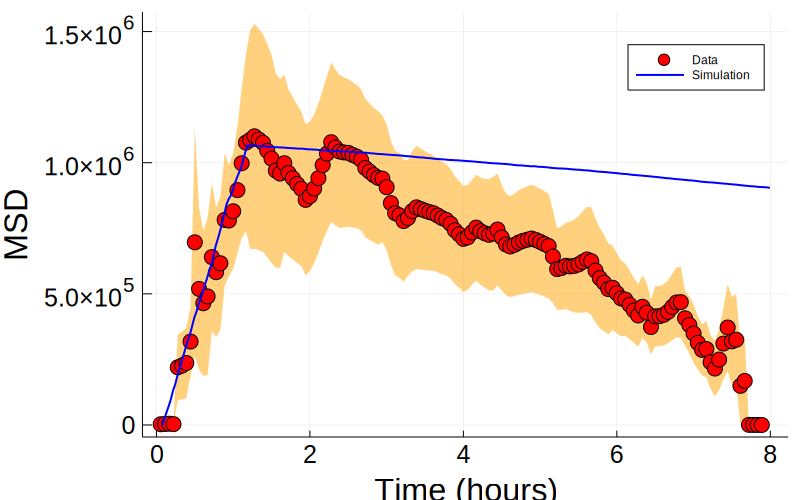

In [81]:
dt = 200
scatter((dt:dt:maximum(ts))./3600., meansd, label="Data",
    ribbon=semsd, fill=:orange, 
    xlabel=string("Time from sunset (hours)"), ylabel="MSD", 
    markersize=8, color=:red,
    size=(800,500),
    tickfontsize=17, guidefontsize=22)

plot!(t./3600 ,msd_sim[1:length(t)],
    xlabel="Time (hours)", ylabel="MSD",label="Simulation",
    linewidth=2, colour=:blue)


In [72]:
savefig(string(path, "figs/RadioTrack_simulation.pdf"))

In [73]:
dt = 200
sstot = 0
ssres_simulation = 0
    for (i,msd) in enumerate(meansd)  
        sstot += (msd - mean(meansd))^2
        ssres_simulation += (msd_sim[i*dt]-msd)^2
    end


r2_simulation = 1 - ssres_simulation/sstot

UndefVarError: UndefVarError: msd_sim not defined